In [1]:
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs

d:\ANACONDA\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
---
title: Denoising Diffusion Probabilistic Models (DDPM) training
summary: >
  Training code for
  Denoising Diffusion Probabilistic Model.
---

# [Denoising Diffusion Probabilistic Models (DDPM)](index.html) training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/experiment.ipynb)

This trains a DDPM based model on CelebA HQ dataset. You can find the download instruction in this
[discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
Save the images inside [`data/celebA` folder](#dataset_path).

The paper had used an exponential moving average of the model with a decay of $0.9999$. We have skipped this for
simplicity.

(obtained from: From: https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/experiment.py)
"""

from typing import List

import torch
import torch.utils.data
import torchvision
import numpy as np

from noise import DenoiseDiffusion
from unet import UNet



def main():
    # Settings for restoring/creating experiment
    global MY_UUID
    global EXP

    LOAD_CHECKPOINT = False # True, False
    MY_UUID = 'AbeSaveTesting4' 
    EXP = 'residual' # 'recurrent', 'residual'

    # Create experiment
    experiment.create(
        name='diffuse',
        writers={'screen', 'labml'},
        uuid=MY_UUID,
    )

    # Create configurations
    configs = Configs()
    print(f'Status: Device is using GPU: {torch.cuda.is_available()}')


    if not LOAD_CHECKPOINT:
        # Set the model
        configs.convolutional_block = EXP

        # Set configurations. You can override the defaults by passing the values in the dictionary.
        experiment.configs(configs, {
            'dataset': 'MNIST',  # 'CIFAR10', 'CelebA' 'MNIST'
            'image_channels': 1,  # 3, 3, 1
            'epochs': 2,  # 100, 100, 5
        })

        # Initialize
        configs.init()

        # Set models for saving and loading
        experiment.add_pytorch_models({'eps_model': configs.eps_model})

        # Start the experiment
        with experiment.start():
            configs.run()   

    elif LOAD_CHECKPOINT:
        my_run_uuid = MY_UUID # Note: set this to the run name you want to load
        my_checkpoint_uuid = None # Note: set this to the checkpoint id from that run. Default is -1 I think but might not be.

        # Load custom configuration of the training run
        configs_dict = experiment.load_configs(my_run_uuid)    

        # Set configurations
        experiment.configs(configs, configs_dict)

        # Set configurations. You can override the defaults by passing the values in the dictionary.
        # MAKE SURE THIS MATCHES THE CHECKPOINT YOURE LOADING. But maybe, to get more epochs from a finished run, you increase epochs.
        # But that's also untested.
        experiment.configs(configs, {
            'dataset': 'MNIST',  # 'CIFAR10', 'CelebA' 'MNIST'
            'image_channels': 1,  # 3, 3, 1
            'epochs': 2,  # 100, 100, 5
        })

        # Initialize
        configs.init()

        # Set PyTorch modules for saving and loading
        experiment.add_pytorch_models({'eps_model': configs.eps_model})

        # Load the experiment from 
        experiment.load(run_uuid=my_run_uuid, checkpoint=my_checkpoint_uuid) # Note: there's also an optional checkpoint number param (checkpoint=[int])

        # Start the experiment (note: not using with experiment.start() when loading)
        with experiment.start():
            configs.run()   




class Configs(BaseConfigs):
    """
    Class for holding configuration parameters for training a DDPM model.

    Attributes:
        device (torch.device):           Device on which to run the model.
        eps_model (UNet):                U-Net model for the function `epsilon_theta`.
        diffusion (DenoiseDiffusion):    DDPM algorithm.
        image_channels (int):            Number of channels in the image (e.g. 3 for RGB).
        image_size (int):                Size of the image.
        n_channels (int):                Number of channels in the initial feature map.
        channel_multipliers (List[int]): Number of channels at each resolution.
        is_attention (List[bool]):       Indicates whether to use attention at each resolution.
        convolutional_block (str):       Type of the convolutional block used
        schedule_name (str):             Function of the noise schedule
        n_steps (int):                   Number of time steps.
        batch_size (int):                Batch size.
        n_samples (int):                 Number of samples to generate.
        learning_rate (float):           Learning rate.
        epochs (int):                    Number of training epochs.
        dataset (torch.utils.data.Dataset):         Dataset to be used for training.
        data_loader (torch.utils.data.DataLoader):  DataLoader for loading the data for training.
        optimizer (torch.optim.Adam):               Optimizer for the model.
    """

    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()
    # Retrieve model information
    show = True

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]
    # Convolutional block type used in the UNet blocks. Possible options are 'residual' and 'recurrent'.
    convolutional_block = 'residual'

    # Defines the noise schedule. Possible options are 'linear' and 'cosine'.
    schedule_name: str = 'linear'
    # Number of time steps $T$ (with $T$ = 1_000 from Ho et al).
    n_steps: int = 1000  # 1000 (Default: Ho et al.)

    # Batch size
    batch_size: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)
    # Number of samples to generate
    n_samples: int = 1
    # Learning rate
    learning_rate: float = 2e-5
    # Number of training epochs
    epochs: int = 100

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        """
        Initialize the model, dataset, and optimizer objects.
        """

        # Create $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
            conv_block=self.convolutional_block
        ).to(self.device)

        # Create [DDPM class](index.html)
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            # schedule_name=self.schedule_name,
            device=self.device,
        )

        # Show the number of params used by the model
        if self.show:
            pytorch_total_params = sum(p.numel() for p in self.eps_model.parameters())
            print(f'The total number of parameters are: {pytorch_total_params}')

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self) -> None:
        """
        Generate samples from a trained Denoising Diffusion Probabilistic Model (DDPM).
        """

        with torch.no_grad():
            # Sample from the noise distribution at the final time step: x_T ~ p(x_T) = N(x_T; 0, I)
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise at each time step in reverse order (so remove noise for T steps)
            for t_ in monit.iterate('Sample', self.n_steps):
                # Get current time step
                t = self.n_steps - t_ - 1
                # Sample from the noise distribution at the current time step: x_{t-1} ~ p_theta(x_{t-1}|x_t)
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log the final denoised samples
            tracker.save('sample', x)

    def train(self) -> None:
        """
        Train a Denoising Diffusion Probabilistic Model (DDPM) with the set dataloader.
        """
        data_steps = 0
        curr_loss = 0
        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)


            # Diagnostics
            curr_loss+=loss.item()
            data_steps+=1

            # print("EARLY STOP: DEBUG PURPOSES ONLY")
            # break

        print(f"Loss after {data_steps} input data seen: {round(curr_loss,2)}")
        with open('loss_log_'+MY_UUID+'_'+EXP+'.txt', 'a', ) as loss_log_file:
            loss_info = "{}, {}".format(data_steps, curr_loss)
            loss_log_file.write(loss_info+'\n')


        # print(data_steps, round(curr_loss, 2))

    def run(self):
        """
        ### Training loop
        """
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            # self.sample()
            
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()

            # break
            print(f"Epoch:", _)


class MNISTDataset(torchvision.datasets.MNIST):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    """
    Create MNIST dataset
    """
    return MNISTDataset(c.image_size)


class CIFAR10Dataset(torchvision.datasets.CIFAR10):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'CIFAR10')
def mnist_dataset(c: Configs):
    """
    Create CIFAR10 dataset
    """
    return CIFAR10Dataset(c.image_size)




In [3]:
main()

ModuleNotFoundError: No module named 'ipywidgets'

In [16]:
# REMEMBER: set LOAD_CHECKPOINT to True if you want to load.
# main()

HTML(value='<pre  style="overflow-x: scroll;"><span style="color: #C5C1B4"></span>\n<span style="color: #C5C1B…

Status: Device is using GPU: False
The total number of parameters are: 129079233


RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down.0.re.conv_input.weight", "down.0.re.norm_input.weight", "down.0.re.norm_input.bias", "down.0.re.skip.weight", "down.0.re.norm_skip.weight", "down.0.re.norm_skip.bias", "down.0.re.conv3.weight", "down.0.re.norm1_0.weight", "down.0.re.norm1_0.bias", "down.0.re.norm3_0.weight", "down.0.re.norm3_0.bias", "down.1.re.conv_input.weight", "down.1.re.norm_input.weight", "down.1.re.norm_input.bias", "down.1.re.skip.weight", "down.1.re.norm_skip.weight", "down.1.re.norm_skip.bias", "down.1.re.conv3.weight", "down.1.re.norm1_0.weight", "down.1.re.norm1_0.bias", "down.1.re.norm3_0.weight", "down.1.re.norm3_0.bias", "down.3.re.conv_input.weight", "down.3.re.norm_input.weight", "down.3.re.norm_input.bias", "down.3.re.skip.weight", "down.3.re.norm_skip.weight", "down.3.re.norm_skip.bias", "down.3.re.conv3.weight", "down.3.re.norm1_0.weight", "down.3.re.norm1_0.bias", "down.3.re.norm3_0.weight", "down.3.re.norm3_0.bias", "down.4.re.conv_input.weight", "down.4.re.norm_input.weight", "down.4.re.norm_input.bias", "down.4.re.skip.weight", "down.4.re.norm_skip.weight", "down.4.re.norm_skip.bias", "down.4.re.conv3.weight", "down.4.re.norm1_0.weight", "down.4.re.norm1_0.bias", "down.4.re.norm3_0.weight", "down.4.re.norm3_0.bias", "down.6.re.conv_input.weight", "down.6.re.norm_input.weight", "down.6.re.norm_input.bias", "down.6.re.skip.weight", "down.6.re.norm_skip.weight", "down.6.re.norm_skip.bias", "down.6.re.conv3.weight", "down.6.re.norm1_0.weight", "down.6.re.norm1_0.bias", "down.6.re.norm3_0.weight", "down.6.re.norm3_0.bias", "down.7.re.conv_input.weight", "down.7.re.norm_input.weight", "down.7.re.norm_input.bias", "down.7.re.skip.weight", "down.7.re.norm_skip.weight", "down.7.re.norm_skip.bias", "down.7.re.conv3.weight", "down.7.re.norm1_0.weight", "down.7.re.norm1_0.bias", "down.7.re.norm3_0.weight", "down.7.re.norm3_0.bias", "down.9.re.conv_input.weight", "down.9.re.norm_input.weight", "down.9.re.norm_input.bias", "down.9.re.skip.weight", "down.9.re.norm_skip.weight", "down.9.re.norm_skip.bias", "down.9.re.conv3.weight", "down.9.re.norm1_0.weight", "down.9.re.norm1_0.bias", "down.9.re.norm3_0.weight", "down.9.re.norm3_0.bias", "down.10.re.conv_input.weight", "down.10.re.norm_input.weight", "down.10.re.norm_input.bias", "down.10.re.skip.weight", "down.10.re.norm_skip.weight", "down.10.re.norm_skip.bias", "down.10.re.conv3.weight", "down.10.re.norm1_0.weight", "down.10.re.norm1_0.bias", "down.10.re.norm3_0.weight", "down.10.re.norm3_0.bias", "middle.re1.conv_input.weight", "middle.re1.norm_input.weight", "middle.re1.norm_input.bias", "middle.re1.skip.weight", "middle.re1.norm_skip.weight", "middle.re1.norm_skip.bias", "middle.re1.conv3.weight", "middle.re1.norm1_0.weight", "middle.re1.norm1_0.bias", "middle.re1.norm3_0.weight", "middle.re1.norm3_0.bias", "middle.re2.conv_input.weight", "middle.re2.norm_input.weight", "middle.re2.norm_input.bias", "middle.re2.skip.weight", "middle.re2.norm_skip.weight", "middle.re2.norm_skip.bias", "middle.re2.conv3.weight", "middle.re2.norm1_0.weight", "middle.re2.norm1_0.bias", "middle.re2.norm3_0.weight", "middle.re2.norm3_0.bias", "up.0.re.conv_input.weight", "up.0.re.norm_input.weight", "up.0.re.norm_input.bias", "up.0.re.skip.weight", "up.0.re.norm_skip.weight", "up.0.re.norm_skip.bias", "up.0.re.conv3.weight", "up.0.re.norm1_0.weight", "up.0.re.norm1_0.bias", "up.0.re.norm3_0.weight", "up.0.re.norm3_0.bias", "up.1.re.conv_input.weight", "up.1.re.norm_input.weight", "up.1.re.norm_input.bias", "up.1.re.skip.weight", "up.1.re.norm_skip.weight", "up.1.re.norm_skip.bias", "up.1.re.conv3.weight", "up.1.re.norm1_0.weight", "up.1.re.norm1_0.bias", "up.1.re.norm3_0.weight", "up.1.re.norm3_0.bias", "up.2.re.conv_input.weight", "up.2.re.norm_input.weight", "up.2.re.norm_input.bias", "up.2.re.skip.weight", "up.2.re.norm_skip.weight", "up.2.re.norm_skip.bias", "up.2.re.conv3.weight", "up.2.re.norm1_0.weight", "up.2.re.norm1_0.bias", "up.2.re.norm3_0.weight", "up.2.re.norm3_0.bias", "up.4.re.conv_input.weight", "up.4.re.norm_input.weight", "up.4.re.norm_input.bias", "up.4.re.skip.weight", "up.4.re.norm_skip.weight", "up.4.re.norm_skip.bias", "up.4.re.conv3.weight", "up.4.re.norm1_0.weight", "up.4.re.norm1_0.bias", "up.4.re.norm3_0.weight", "up.4.re.norm3_0.bias", "up.5.re.conv_input.weight", "up.5.re.norm_input.weight", "up.5.re.norm_input.bias", "up.5.re.skip.weight", "up.5.re.norm_skip.weight", "up.5.re.norm_skip.bias", "up.5.re.conv3.weight", "up.5.re.norm1_0.weight", "up.5.re.norm1_0.bias", "up.5.re.norm3_0.weight", "up.5.re.norm3_0.bias", "up.6.re.conv_input.weight", "up.6.re.norm_input.weight", "up.6.re.norm_input.bias", "up.6.re.skip.weight", "up.6.re.norm_skip.weight", "up.6.re.norm_skip.bias", "up.6.re.conv3.weight", "up.6.re.norm1_0.weight", "up.6.re.norm1_0.bias", "up.6.re.norm3_0.weight", "up.6.re.norm3_0.bias", "up.8.re.conv_input.weight", "up.8.re.norm_input.weight", "up.8.re.norm_input.bias", "up.8.re.skip.weight", "up.8.re.norm_skip.weight", "up.8.re.norm_skip.bias", "up.8.re.conv3.weight", "up.8.re.norm1_0.weight", "up.8.re.norm1_0.bias", "up.8.re.norm3_0.weight", "up.8.re.norm3_0.bias", "up.9.re.conv_input.weight", "up.9.re.norm_input.weight", "up.9.re.norm_input.bias", "up.9.re.skip.weight", "up.9.re.norm_skip.weight", "up.9.re.norm_skip.bias", "up.9.re.conv3.weight", "up.9.re.norm1_0.weight", "up.9.re.norm1_0.bias", "up.9.re.norm3_0.weight", "up.9.re.norm3_0.bias", "up.10.re.conv_input.weight", "up.10.re.norm_input.weight", "up.10.re.norm_input.bias", "up.10.re.skip.weight", "up.10.re.norm_skip.weight", "up.10.re.norm_skip.bias", "up.10.re.conv3.weight", "up.10.re.norm1_0.weight", "up.10.re.norm1_0.bias", "up.10.re.norm3_0.weight", "up.10.re.norm3_0.bias", "up.12.re.conv_input.weight", "up.12.re.norm_input.weight", "up.12.re.norm_input.bias", "up.12.re.skip.weight", "up.12.re.norm_skip.weight", "up.12.re.norm_skip.bias", "up.12.re.conv3.weight", "up.12.re.norm1_0.weight", "up.12.re.norm1_0.bias", "up.12.re.norm3_0.weight", "up.12.re.norm3_0.bias", "up.13.re.conv_input.weight", "up.13.re.norm_input.weight", "up.13.re.norm_input.bias", "up.13.re.skip.weight", "up.13.re.norm_skip.weight", "up.13.re.norm_skip.bias", "up.13.re.conv3.weight", "up.13.re.norm1_0.weight", "up.13.re.norm1_0.bias", "up.13.re.norm3_0.weight", "up.13.re.norm3_0.bias", "up.14.re.conv_input.weight", "up.14.re.norm_input.weight", "up.14.re.norm_input.bias", "up.14.re.skip.weight", "up.14.re.norm_skip.weight", "up.14.re.norm_skip.bias", "up.14.re.conv3.weight", "up.14.re.norm1_0.weight", "up.14.re.norm1_0.bias", "up.14.re.norm3_0.weight", "up.14.re.norm3_0.bias". 
	Unexpected key(s) in state_dict: "down.0.re.norm1.weight", "down.0.re.norm1.bias", "down.0.re.norm2.weight", "down.0.re.norm2.bias", "down.0.re.conv2.weight", "down.0.re.conv2.bias", "down.0.re.conv1.bias", "down.1.re.norm1.weight", "down.1.re.norm1.bias", "down.1.re.norm2.weight", "down.1.re.norm2.bias", "down.1.re.conv2.weight", "down.1.re.conv2.bias", "down.1.re.conv1.bias", "down.3.re.norm1.weight", "down.3.re.norm1.bias", "down.3.re.norm2.weight", "down.3.re.norm2.bias", "down.3.re.conv2.weight", "down.3.re.conv2.bias", "down.3.re.conv1.bias", "down.4.re.norm1.weight", "down.4.re.norm1.bias", "down.4.re.norm2.weight", "down.4.re.norm2.bias", "down.4.re.conv2.weight", "down.4.re.conv2.bias", "down.4.re.conv1.bias", "down.6.re.norm1.weight", "down.6.re.norm1.bias", "down.6.re.norm2.weight", "down.6.re.norm2.bias", "down.6.re.conv2.weight", "down.6.re.conv2.bias", "down.6.re.conv1.bias", "down.7.re.norm1.weight", "down.7.re.norm1.bias", "down.7.re.norm2.weight", "down.7.re.norm2.bias", "down.7.re.conv2.weight", "down.7.re.conv2.bias", "down.7.re.conv1.bias", "down.9.re.norm1.weight", "down.9.re.norm1.bias", "down.9.re.norm2.weight", "down.9.re.norm2.bias", "down.9.re.conv2.weight", "down.9.re.conv2.bias", "down.9.re.conv1.bias", "down.10.re.norm1.weight", "down.10.re.norm1.bias", "down.10.re.norm2.weight", "down.10.re.norm2.bias", "down.10.re.conv2.weight", "down.10.re.conv2.bias", "down.10.re.conv1.bias", "middle.re1.norm1.weight", "middle.re1.norm1.bias", "middle.re1.norm2.weight", "middle.re1.norm2.bias", "middle.re1.conv2.weight", "middle.re1.conv2.bias", "middle.re1.conv1.bias", "middle.re2.norm1.weight", "middle.re2.norm1.bias", "middle.re2.norm2.weight", "middle.re2.norm2.bias", "middle.re2.conv2.weight", "middle.re2.conv2.bias", "middle.re2.conv1.bias", "up.0.re.norm1.weight", "up.0.re.norm1.bias", "up.0.re.norm2.weight", "up.0.re.norm2.bias", "up.0.re.conv2.weight", "up.0.re.conv2.bias", "up.0.re.conv1.bias", "up.1.re.norm1.weight", "up.1.re.norm1.bias", "up.1.re.norm2.weight", "up.1.re.norm2.bias", "up.1.re.conv2.weight", "up.1.re.conv2.bias", "up.1.re.conv1.bias", "up.2.re.norm1.weight", "up.2.re.norm1.bias", "up.2.re.norm2.weight", "up.2.re.norm2.bias", "up.2.re.conv2.weight", "up.2.re.conv2.bias", "up.2.re.conv1.bias", "up.4.re.norm1.weight", "up.4.re.norm1.bias", "up.4.re.norm2.weight", "up.4.re.norm2.bias", "up.4.re.conv2.weight", "up.4.re.conv2.bias", "up.4.re.conv1.bias", "up.5.re.norm1.weight", "up.5.re.norm1.bias", "up.5.re.norm2.weight", "up.5.re.norm2.bias", "up.5.re.conv2.weight", "up.5.re.conv2.bias", "up.5.re.conv1.bias", "up.6.re.norm1.weight", "up.6.re.norm1.bias", "up.6.re.norm2.weight", "up.6.re.norm2.bias", "up.6.re.conv2.weight", "up.6.re.conv2.bias", "up.6.re.conv1.bias", "up.8.re.norm1.weight", "up.8.re.norm1.bias", "up.8.re.norm2.weight", "up.8.re.norm2.bias", "up.8.re.conv2.weight", "up.8.re.conv2.bias", "up.8.re.conv1.bias", "up.9.re.norm1.weight", "up.9.re.norm1.bias", "up.9.re.norm2.weight", "up.9.re.norm2.bias", "up.9.re.conv2.weight", "up.9.re.conv2.bias", "up.9.re.conv1.bias", "up.10.re.norm1.weight", "up.10.re.norm1.bias", "up.10.re.norm2.weight", "up.10.re.norm2.bias", "up.10.re.conv2.weight", "up.10.re.conv2.bias", "up.10.re.conv1.bias", "up.12.re.norm1.weight", "up.12.re.norm1.bias", "up.12.re.norm2.weight", "up.12.re.norm2.bias", "up.12.re.conv2.weight", "up.12.re.conv2.bias", "up.12.re.conv1.bias", "up.13.re.norm1.weight", "up.13.re.norm1.bias", "up.13.re.norm2.weight", "up.13.re.norm2.bias", "up.13.re.conv2.weight", "up.13.re.conv2.bias", "up.13.re.conv1.bias", "up.14.re.norm1.weight", "up.14.re.norm1.bias", "up.14.re.norm2.weight", "up.14.re.norm2.bias", "up.14.re.conv2.weight", "up.14.re.conv2.bias", "up.14.re.conv1.bias". 
	size mismatch for down.0.re.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for down.0.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for down.0.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down.1.re.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for down.1.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for down.1.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down.3.re.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for down.3.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for down.3.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down.4.re.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for down.4.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for down.4.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down.6.re.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for down.6.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for down.6.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down.7.re.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for down.7.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for down.7.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down.9.re.conv1.weight: copying a param with shape torch.Size([1024, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for down.9.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for down.9.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for down.10.re.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for down.10.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for down.10.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for middle.re1.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for middle.re1.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for middle.re1.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for middle.re2.conv1.weight: copying a param with shape torch.Size([1024, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for middle.re2.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for middle.re2.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.0.re.conv1.weight: copying a param with shape torch.Size([1024, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for up.0.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for up.0.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.1.re.conv1.weight: copying a param with shape torch.Size([1024, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for up.1.re.time_emb.weight: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for up.1.re.time_emb.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for up.2.re.conv1.weight: copying a param with shape torch.Size([256, 1280, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.2.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.2.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.4.re.conv1.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.4.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.4.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.5.re.conv1.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for up.5.re.time_emb.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for up.5.re.time_emb.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up.6.re.conv1.weight: copying a param with shape torch.Size([128, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.6.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.6.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.8.re.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.8.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.8.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.9.re.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for up.9.re.time_emb.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for up.9.re.time_emb.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up.10.re.conv1.weight: copying a param with shape torch.Size([64, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.10.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.10.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.12.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.12.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.12.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.13.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.13.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.13.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up.14.re.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for up.14.re.time_emb.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for up.14.re.time_emb.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).

HTML(value='<pre  style="overflow-x: scroll;"><span style="color: #C5C1B4"></span>\n<span style="color: #C5C1B…

The total number of parameters are: 173987521


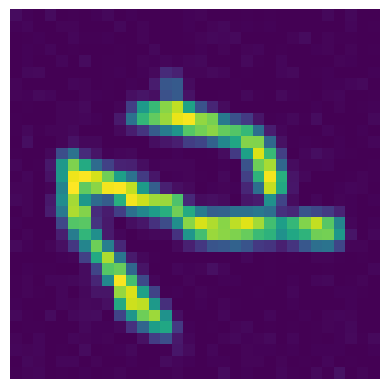

In [13]:
"""
---
title: Denoising Diffusion Probabilistic Models (DDPM) evaluation/sampling
summary: >
  Code to generate samples from a trained
  Denoising Diffusion Probabilistic Model.
---
# [Denoising Diffusion Probabilistic Models (DDPM)](index.html) evaluation/sampling
This is the code to generate images and create interpolations between given images.
"""
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image, resize

from labml import experiment, monit
from noise import DenoiseDiffusion, gather
# from __main__ import Configs

from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from noise import DenoiseDiffusion
from unet import UNet
from typing import List, Tuple


class Sampler:
    """
    ## Sampler class
    """

    def __init__(self, diffusion: DenoiseDiffusion, image_channels: int, image_size: int, device: torch.device):
        """
        * `diffusion` is the `DenoiseDiffusion` instance
        * `image_channels` is the number of channels in the image
        * `image_size` is the image size
        * `device` is the device of the model
        """
        self.device = device
        self.image_size = image_size
        self.image_channels = image_channels
        self.diffusion = diffusion

        # $T$
        self.n_steps = diffusion.n_steps
        # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
        self.eps_model = diffusion.eps_model
        # $\beta_t$
        self.beta = diffusion.beta
        # $\alpha_t$
        self.alpha = diffusion.alpha
        # $\bar\alpha_t$
        self.alpha_bar = diffusion.alpha_bar
        # $\bar\alpha_{t-1}$
        alpha_bar_tm1 = torch.cat([self.alpha_bar.new_ones((1,)), self.alpha_bar[:-1]])

        # To calculate
        #
        # \begin{align}
        # q(x_{t-1}|x_t, x_0) &= \mathcal{N} \Big(x_{t-1}; \tilde\mu_t(x_t, x_0), \tilde\beta_t \mathbf{I} \Big) \\
        # \tilde\mu_t(x_t, x_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}x_0
        #                          + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})}{1-\bar\alpha_t}x_t \\
        # \tilde\beta_t &= \frac{1 - \bar\alpha_{t-1}}{a}
        # \end{align}

        # $\tilde\beta_t$
        self.beta_tilde = self.beta * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
        # $$\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}$$
        self.mu_tilde_coef1 = self.beta * (alpha_bar_tm1 ** 0.5) / (1 - self.alpha_bar)
        # $$\frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1}}{1-\bar\alpha_t}$$
        self.mu_tilde_coef2 = (self.alpha ** 0.5) * (1 - alpha_bar_tm1) / (1 - self.alpha_bar)
        # $\sigma^2 = \beta$
        self.sigma2 = self.beta

    def show_image(self, img, title=""):
        """Helper function to display an image"""
        img = img.clip(0, 1)
        img = img.cpu().numpy()
        plt.imshow(img.transpose(1, 2, 0))
        plt.axis("off")
        dirs = 'result_image'
        if not os.path.exists(dirs):
            os.makedirs(dirs)
        path = dirs + '/' + title + '.jpg'
        plt.savefig(path)
        # plt.title(title)
        # plt.show()

    def make_video(self, frames, path="video.mp4"):
        """Helper function to create a video"""
        import imageio
        # 20 second video
        writer = imageio.get_writer(path, fps=len(frames) // 20)
        # Add each image
        for f in frames:
            f = f.clip(0, 1)
            f = to_pil_image(resize(f, [368, 368]))
            writer.append_data(np.array(f))
        #
        writer.close()

    def sample_animation(self, n_frames: int = 1000, create_video: bool = True):
        """
        #### Sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        We sample an image step-by-step using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$ and at each step
        show the estimate
        $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
         \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        """

        # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
        xt = torch.randn([1, self.image_channels, self.image_size, self.image_size], device=self.device)

        # Interval to log $\hat{x}_0$
        interval = self.n_steps // n_frames
        # Frames for video
        frames = []
        # Sample $T$ steps
        for t_inv in monit.iterate('Denoise', self.n_steps):
            # $t$
            t_ = self.n_steps - t_inv - 1
            # $t$ in a tensor
            t = xt.new_full((1,), t_, dtype=torch.long)
            # $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
            eps_theta = self.eps_model(xt, t)
            if t_ % interval == 0:
                # Get $\hat{x}_0$ and add to frames
                x0 = self.p_x0(xt, t, eps_theta)
                frames.append(x0[0])
                if not create_video:
                    self.show_image(x0[0], f"{t_}")
            # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
            xt = self.p_sample(xt, t, eps_theta)

        # Make video
        if create_video:
            self.make_video(frames)

    def interpolate(self, x1: torch.Tensor, x2: torch.Tensor, lambda_: float, t_: int = 100):
        """
        #### Interpolate two images $x_0$ and $x'_0$
        We get $x_t \sim q(x_t|x_0)$ and $x'_t \sim q(x'_t|x_0)$.
        Then interpolate to
         $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
        Then get
         $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
        * `x1` is $x_0$
        * `x2` is $x'_0$
        * `lambda_` is $\lambda$
        * `t_` is $t$
        """

        # Number of samples
        n_samples = x1.shape[0]
        # $t$ tensor
        t = torch.full((n_samples,), t_, device=self.device)
        # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
        xt = (1 - lambda_) * self.diffusion.q_sample(x1, t) + lambda_ * self.diffusion.q_sample(x2, t)

        # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
        return self._sample_x0(xt, t_)

    def interpolate_animate(self, x1: torch.Tensor, x2: torch.Tensor, n_frames: int = 100, t_: int = 100,
                            create_video=True):
        """
        #### Interpolate two images $x_0$ and $x'_0$ and make a video
        * `x1` is $x_0$
        * `x2` is $x'_0$
        * `n_frames` is the number of frames for the image
        * `t_` is $t$
        * `create_video` specifies whether to make a video or to show each frame
        """

        # Show original images
        self.show_image(x1, "x1")
        self.show_image(x2, "x2")
        # Add batch dimension
        x1 = x1[None, :, :, :]
        x2 = x2[None, :, :, :]
        # $t$ tensor
        t = torch.full((1,), t_, device=self.device)
        # $x_t \sim q(x_t|x_0)$
        x1t = self.diffusion.q_sample(x1, t)
        # $x'_t \sim q(x'_t|x_0)$
        x2t = self.diffusion.q_sample(x2, t)

        frames = []
        # Get frames with different $\lambda$
        for i in monit.iterate('Interpolate', n_frames + 1, is_children_silent=True):
            # $\lambda$
            lambda_ = i / n_frames
            # $$\bar{x}_t = (1 - \lambda)x_t + \lambda x'_0$$
            xt = (1 - lambda_) * x1t + lambda_ * x2t
            # $$\bar{x}_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|\bar{x}_t)$$
            x0 = self._sample_x0(xt, t_)
            # Add to frames
            frames.append(x0[0])
            # Show frame
            if not create_video:
                self.show_image(x0[0], f"{lambda_ :.2f}")

        # Make video
        if create_video:
            self.make_video(frames)

    def _sample_x0(self, xt: torch.Tensor, n_steps: int):
        """
        #### Sample an image using $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        * `xt` is $x_t$
        * `n_steps` is $t$
        """

        # Number of sampels
        n_samples = xt.shape[0]
        # Iterate until $t$ steps
        for t_ in monit.iterate('Denoise', n_steps):
            t = n_steps - t_ - 1
            # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
            xt = self.diffusion.p_sample(xt, xt.new_full((n_samples,), t, dtype=torch.long))

        # Return $x_0$
        return xt

    def sample(self, n_samples: int = 16):
        """
        #### Generate images
        """
        # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
        xt = torch.randn([n_samples, self.image_channels, self.image_size, self.image_size], device=self.device)

        # $$x_0 \sim \textcolor{lightgreen}{p_\theta}(x_0|x_t)$$
        x0 = self._sample_x0(xt, self.n_steps)
        torch.save(x0,"model_output.pt")
        # Show images
        path = './result_image'
        isExists = os.path.exists(path)
        if not isExists:
            os.makedirs(path)

        for i in range(n_samples):
            # torch.save(x0,"model_output.pt")
            # self.show_image(x0[i])
            self.show_image(x0[i],title = str(i))

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, eps_theta: torch.Tensor):
        """
        #### Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        \begin{align}
        \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \textcolor{lightgreen}{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \textcolor{lightgreen}{\mu_\theta}(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
        \end{align}
        """
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
        # $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        # $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
        #      \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # $\sigma^2$
        var = gather(self.sigma2, t)

        # $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def p_x0(self, xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor):
        """
        #### Estimate $x_0$
        $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
         \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        """
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)

        # $$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
        #  \Big( x_t - \sqrt{1 - \bar\alpha_t} \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)$$
        return (xt - (1 - alpha_bar) ** 0.5 * eps) / (alpha_bar ** 0.5)




class Configs(BaseConfigs):
    """
    Class for holding configuration parameters for training a DDPM model.

    Attributes:
        device (torch.device):           Device on which to run the model.
        show (bool):                     Extract model information.
        eps_model (UNet):                U-Net model for the function `epsilon_theta`.
        diffusion (DenoiseDiffusion):    DDPM algorithm.
        image_channels (int):            Number of channels in the image (e.g. 3 for RGB).
        image_size (int):                Size of the image.
        n_channels (int):                Number of channels in the initial feature map.
        epochs (int):                    Number of training epochs.
        batch_size (int):                Batch size.
        clip (float):                    Magnitude of maximal gradients allowed.
        dropout (float):                 The probability for the dropout of units.
        channel_multipliers (List[int]): Number of channels at each resolution.
        is_attention (List[bool]):       Indicates whether to use attention at each resolution.
        convolutional_block (str):       Type of the convolutional block used
        n_steps (int):                   Number of time steps.
        n_samples (int):                 Number of samples to generate.
        learning_rate (float):           Learning rate.
        dataset (torch.utils.data.Dataset):         Dataset to be used for training.
        data_loader (torch.utils.data.DataLoader):  DataLoader for loading the data for training.
        optimizer (torch.optim.Adam):               Optimizer for the model.
    """
    # Device to train the model on.
    # [`DeviceConfigs`
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()
    # Retrieve model information
    show: bool = True

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)

    # Batch size
    batch_size: int = 64  # 64 (Default: Ho et al.; Limit is VRAM)
    # Number of training epochs
    epochs: int = 1000

    # Learning rate
    learning_rate: float = 2e-5
    # Set maximal gradient value
    clip: float = 1.0
    # Set the dropout probability
    dropout: float = 0.1
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]
    # Convolutional block type used in the UNet blocks. Possible options are 'residual' and 'recurrent'.
    convolutional_block: str = 'recurrent'

    # Number of time steps $T$ (with $T$ = 1_000 from Ho et al).
    n_steps: int = 1000  # 1000 (Default: Ho et al.)
    # Number of samples to generate
    n_samples: int = 16

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        """
        Initialize the model, dataset, and optimizer objects.
        """
        # Create εθ(x_t, t) model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            dropout=self.dropout,
            is_attn=self.is_attention,
            conv_block=self.convolutional_block
        ).to(self.device)

        # Create [DDPM class]
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Show the number of params used by the model
        if self.show:
            pytorch_total_params = sum(p.numel() for p in self.eps_model.parameters())
            print(f'The total number of parameters are: {pytorch_total_params}')
        # Data augmentation (skipped, due to runtime)
        # self.augment()
        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self) -> None:
        """
        Generate samples from a trained Denoising Diffusion Probabilistic Model (DDPM).
        """
        with torch.no_grad():
            # Sample from the noise distribution at the final time step: x_T ~ p(x_T) = N(x_T; 0, I)
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise at each time step in reverse order (so remove noise for T steps)
            for t_ in monit.iterate('Sample', self.n_steps):
                # Get current time step
                t = self.n_steps - t_ - 1
                # Sample from the noise distribution at the current time step: x_{t-1} ~ p_theta(x_{t-1}|x_t)
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log the final denoised samples
            tracker.save('sample', x)

    def augment(self):
        """
        Augment the data set with color jittering (brithness, contrast, saturation, and hue) and
        affine transformations (ratation, translation, scaling and shearing). Used to increase the data set size,
        making the predictions more robust to attain view point invariance.
        """

        if len(self.dataset.data.shape) == 3:
            self.dataset.data = self.dataset.data[:, None, :, :]

        transformations = [T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                           T.RandomAffine(degrees=90, translate=(0, 0.5), scale=(0.5, 0.5), shear=(0, 0.5))]

        for transform in transformations:
            img_trans = transform(self.dataset.data)
            self.dataset.data = torch.cat((img_trans, self.dataset.data), dim=0)
            self.dataset.targets = torch.cat((self.dataset.targets, self.dataset.targets), dim=0)
        self.dataset.data = torch.squeeze(self.dataset.data)

    def train(self) -> None:
        """
        Train a Denoising Diffusion Probabilistic Model (DDPM) with the set dataloader.
        """
        data_steps = 0
        curr_loss = 0
        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Clip model gradients
            # clip_grad_value_(parameters=self.eps_model.parameters(), clip_value=self.clip)
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)
            curr_loss+=loss.item()
            data_steps+=1
        print(f"Loss after {data_steps} input data seen: {round(curr_loss,2)}")
        dirs = 'loss_log_'+"recurrent"+'mnist'+'.txt'

        with open(dirs, 'a', ) as loss_log_file:
            loss_info = "{}, {}".format(data_steps, curr_loss)
            loss_log_file.write(loss_info+'\n')

    def run(self):
        """
        ### Training loop
        """
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            # self.sample()
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()



def main():
    """Generate samples"""

    # Training experiment run UUID
    run_uuid = "new_recurrent_mnist"

    # Start an evaluation
    experiment.evaluate()

    # Create configs
    configs = Configs()
    # Load custom configuration of the training run
    configs_dict = experiment.load_configs(run_uuid)
    # Set configurations
    experiment.configs(configs, configs_dict)

    # NOTE: This needs to be remembered manually it seems...

    # Set configurations. You can override the defaults by passing the values in the dictionary.
    experiment.configs(configs, {
        'dataset': 'MNIST',  # 'CIFAR10', 'CelebA' 'MNIST'
        'image_channels': 1,  # 3, 3, 1
        'epochs': 5,  # 100, 100, 5
    })

    # Initialize
    configs.init()

    # Set PyTorch modules for saving and loading
    experiment.add_pytorch_models({'eps_model': configs.eps_model})

    # Load training experiment
    experiment.load(run_uuid=run_uuid, checkpoint=64906)

    # Create sampler
    sampler = Sampler(diffusion=configs.diffusion,
                      image_channels=configs.image_channels,
                      image_size=configs.image_size,
                      device=configs.device)

    # Start evaluation
    with experiment.start():
        # No gradients
        with torch.no_grad():
            # Sample an image with an denoising animation
            sampler.sample_animation()
            sampler.sample(n_samples = 2)
            if False:
                # Get some images fro data
                data = next(iter(configs.data_loader)).to(configs.device)

                # Create an interpolation animation
                sampler.interpolate_animate(data[0], data[1])


#
if __name__ == '__main__':
    main()